This notebook explores the distribution of freesurfer features across versions 6 and 7 and compares that with those of UKB subjects. These comparasions are done across groups as well(M/F and AD/CN/MCI).

There are scatterplot which show much a feature has changed acorss versions 6 and 7 In ADNI.

It also has code to train a RF classification model which is trained on ADNI FS features and does prediction on UKB dataset to predict the diagnosis group of a subject.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, train_test_split
import calibration as cal

In [2]:
ukb_adni_directory_path="/ocean/projects/asc170022p/tighu/ADNI_UKB_Harmonization_May_2022/"
temp_df=pd.read_csv(ukb_adni_directory_path+"imaging_features_for_longcomb_update_11_12_2021_rename_cols.csv")

In [3]:
temp_df.head(5)

,Subject_ID,Group,Sex,Age,Date_of_Brain_Scan,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,...,DXAATYSP,DXAMETSP,DXAOTHSP,DXPARK,DXPOTHSP,DXOOTHSP,update_stamp,True Diagnosis,date_diff,Scanner_Proxy
0,941_S_1202,CN,M,79,2/28/08,2.224,2.397,2.262,1.694,2.256,...,-4,-4,-4,-4,-4,-4,00:00.0,CN,3,1.5T 127
1,941_S_1202,CN,M,81,3/14/10,2.172,2.393,2.296,1.567,2.243,...,-4,-4,-4,-4,-4,-4,00:00.0,MCI,4,1.5T 127
2,941_S_1202,CN,M,80,2/17/09,2.266,2.417,2.280,1.613,2.344,...,-4,-4,-4,-4,-4,-4,00:00.0,MCI,7,1.5T 127
3,941_S_1202,CN,M,78,1/30/07,2.299,2.491,2.350,1.663,2.388,...,-4,-4,-4,-4,-4,-4,00:00.0,CN,13,1.5T 127
4,941_S_1202,CN,M,78,8/24/07,2.330,2.418,2.311,1.680,2.372,...,-4,-4,-4,-4,-4,-4,00:00.0,CN,9,1.5T 127


In [4]:
fs6_df=pd.read_csv(ukb_adni_directory_path+"adni_6_ukb_stacked_may2022.csv")
fs7_df=pd.read_csv("adni_ukb_stacked_april19.csv")
fs6_df=fs6_df[fs6_df['Dataset']=="ADNI"]
fs7_df=fs7_df[fs7_df['Dataset']=="ADNI"]
fs6_df=fs6_df.reset_index(drop=True)
fs7_df=fs7_df.reset_index(drop=True)
df_merged = pd.merge(fs6_df, fs7_df,  how='left', left_on=['Subject_ID','Date_of_Brain_Scan','Scanner_Proxy'], right_on = ['Subject_ID','Date_of_Brain_Scan','Scanner_Proxy'],suffixes=("_ver6","_ver7"))
def get_true_diagnosis(row):
    subject_id,date_of_scan,scanner = row["Subject_ID"],row["Date_of_Brain_Scan"],row["Scanner_Proxy"]
    return temp_df[(temp_df.Subject_ID==subject_id) & (temp_df.Date_of_Brain_Scan==date_of_scan) & (temp_df.Scanner_Proxy==scanner)]["True Diagnosis"].values[0]
df_merged["True_Diagnosis"]=df_merged.apply(lambda x: get_true_diagnosis(x),axis=1)

/ocean/projects/asc170022p/tighu/anaconda/envs/bridges2base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
df_merged["True_Diagnosis"].value_counts()

MCI    1428
CN     1077
AD      960
Name: True_Diagnosis, dtype: int64

In [6]:
temp_df["True Diagnosis"].value_counts()

MCI    1438
CN     1080
AD      975
Name: True Diagnosis, dtype: int64

In [7]:
list(df_merged.columns)

['Subject_ID',
 'Group_ver6',
 'Sex_ver6',
 'Age_ver6',
 'Date_of_Brain_Scan',
 'Scanner_Proxy',
 'lh_bankssts_thickness_ver6',
 'lh_caudalanteriorcingulate_thickness_ver6',
 'lh_caudalmiddlefrontal_thickness_ver6',
 'lh_cuneus_thickness_ver6',
 'lh_entorhinal_thickness_ver6',
 'lh_fusiform_thickness_ver6',
 'lh_inferiorparietal_thickness_ver6',
 'lh_inferiortemporal_thickness_ver6',
 'lh_isthmuscingulate_thickness_ver6',
 'lh_lateraloccipital_thickness_ver6',
 'lh_lateralorbitofrontal_thickness_ver6',
 'lh_lingual_thickness_ver6',
 'lh_medialorbitofrontal_thickness_ver6',
 'lh_middletemporal_thickness_ver6',
 'lh_parahippocampal_thickness_ver6',
 'lh_paracentral_thickness_ver6',
 'lh_parsopercularis_thickness_ver6',
 'lh_parsorbitalis_thickness_ver6',
 'lh_parstriangularis_thickness_ver6',
 'lh_pericalcarine_thickness_ver6',
 'lh_postcentral_thickness_ver6',
 'lh_posteriorcingulate_thickness_ver6',
 'lh_precentral_thickness_ver6',
 'lh_precuneus_thickness_ver6',
 'lh_rostralanteriorci

In [8]:
df_merged.head(5)

,Subject_ID,Group_ver6,Sex_ver6,Age_ver6,Date_of_Brain_Scan,Scanner_Proxy,lh_bankssts_thickness_ver6,lh_caudalanteriorcingulate_thickness_ver6,lh_caudalmiddlefrontal_thickness_ver6,lh_cuneus_thickness_ver6,...,SubCortGrayVol_ver7,TotalGrayVol_ver7,SupraTentorialVol_ver7,SupraTentorialVolNotVent_ver7,MaskVol_ver7,BrainSegVol_to_eTIV,MaskVol_to_eTIV,EstimatedTotalIntraCranialVol_ver7,Dataset_ver7,True_Diagnosis
0,941_S_1202,CN,M,79,2/28/08,1.5T 127,2.213,2.742,2.166,1.601,...,49057,606091.6119,991856.0,923709.0,1764586,0.672755,1.045520,1687759.933,ADNI,CN
1,941_S_1202,MCI,M,81,3/14/10,1.5T 127,2.221,2.795,2.187,1.612,...,47331,587144.3047,970775.0,896213.0,1766552,0.656299,1.046684,1687759.933,ADNI,MCI
2,941_S_1202,MCI,M,80,2/17/09,1.5T 127,2.261,2.867,2.197,1.660,...,48801,600657.1456,979765.0,910295.0,1764064,0.664570,1.045210,1687759.933,ADNI,MCI
3,941_S_1202,CN,M,78,1/30/07,1.5T 127,2.313,2.682,2.296,1.626,...,49949,620523.4482,1000323.0,934434.0,1766094,0.679663,1.046413,1687759.933,ADNI,CN
4,941_S_1202,CN,M,78,8/24/07,1.5T 127,2.425,2.761,2.240,1.668,...,50001,611566.2365,987688.0,921306.0,1764805,0.671846,1.045649,1687759.933,ADNI,CN


In [9]:
def make_box_plot(title,xlabel,data,labels):
    
    plt.boxplot(data,labels=labels)
    plt.xlabel(xlabel, fontsize=25)
    plt.title(title,fontsize=35)
    plt.show()

## Box Plots Freesurfer ver6 vs ver7

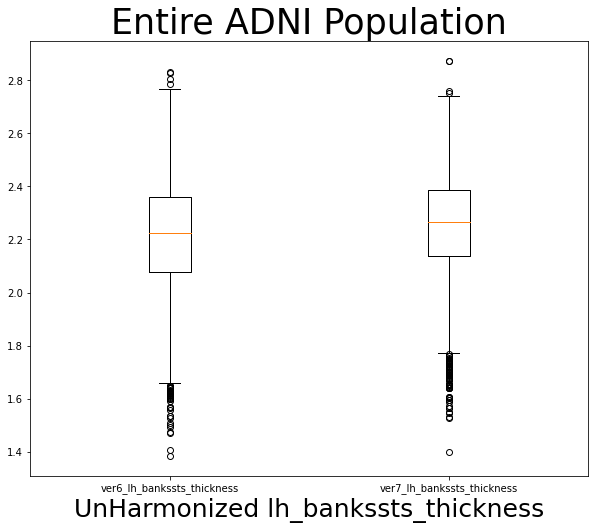

In [10]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged['lh_bankssts_thickness_ver6'],df_merged['lh_bankssts_thickness_ver7']]
labels=["ver6_lh_bankssts_thickness","ver7_lh_bankssts_thickness"]
make_box_plot("Entire ADNI Population","UnHarmonized lh_bankssts_thickness",data,labels)

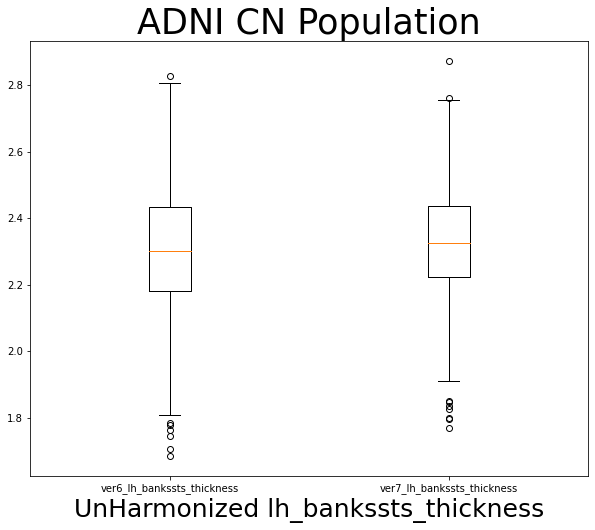

In [11]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged.True_Diagnosis=="CN"]['lh_bankssts_thickness_ver6'],df_merged[df_merged.True_Diagnosis=="CN"]['lh_bankssts_thickness_ver7']]
labels=["ver6_lh_bankssts_thickness","ver7_lh_bankssts_thickness"]
make_box_plot("ADNI CN Population","UnHarmonized lh_bankssts_thickness",data,labels)

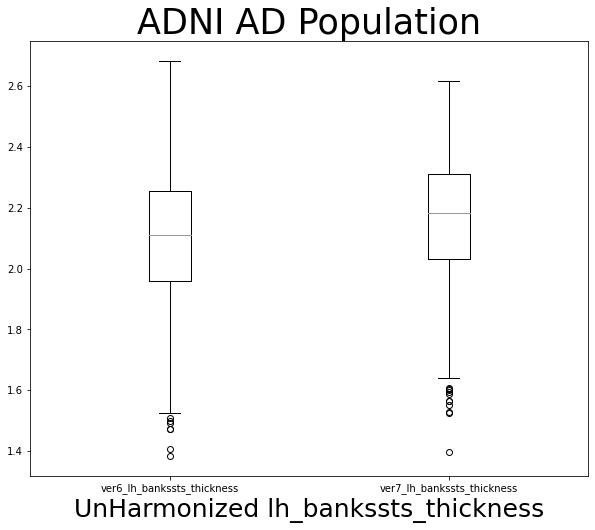

In [12]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged.True_Diagnosis=="AD"]['lh_bankssts_thickness_ver6'],df_merged[df_merged.True_Diagnosis=="AD"]['lh_bankssts_thickness_ver7']]
labels=["ver6_lh_bankssts_thickness","ver7_lh_bankssts_thickness"]
make_box_plot("ADNI AD Population","UnHarmonized lh_bankssts_thickness",data,labels)

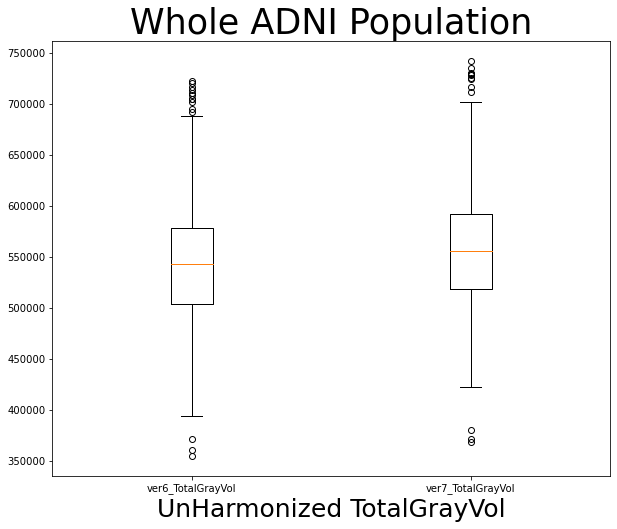

In [13]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged['TotalGrayVol_ver6'],df_merged['TotalGrayVol_ver7']]
labels=["ver6_TotalGrayVol","ver7_TotalGrayVol"]
make_box_plot("Whole ADNI Population","UnHarmonized TotalGrayVol",data,labels)

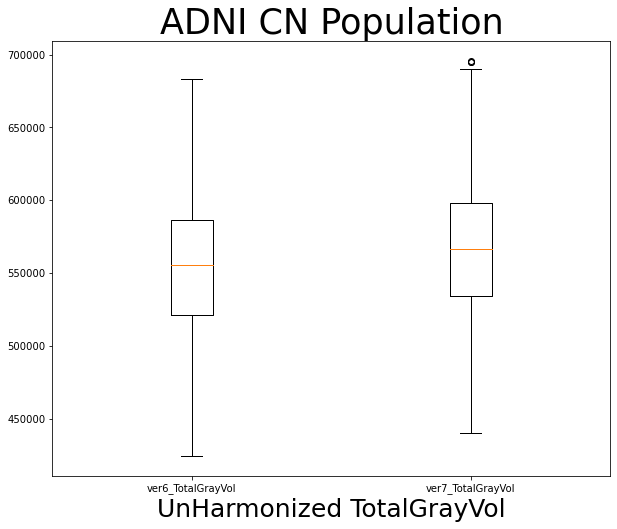

In [14]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver6'],df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver7']]
labels=["ver6_TotalGrayVol","ver7_TotalGrayVol"]
make_box_plot("ADNI CN Population","UnHarmonized TotalGrayVol",data,labels)

In [15]:
from scipy.stats import ttest_rel
ttest_rel(df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver6'], df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver7'])

bias = df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver7'].mean()-df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver6'].mean()     
print(bias)
bias / df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver7'].mean()

12481.022080466384


0.022013483959303328

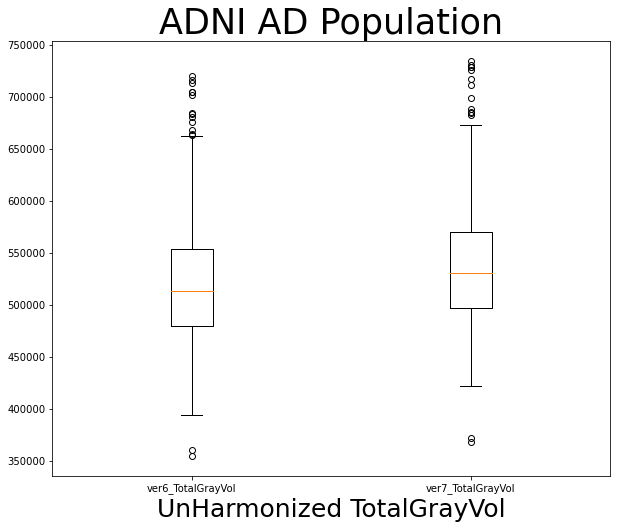

In [16]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged.True_Diagnosis=="AD"]['TotalGrayVol_ver6'],df_merged[df_merged.True_Diagnosis=="AD"]['TotalGrayVol_ver7']]
labels=["ver6_TotalGrayVol","ver7_TotalGrayVol"]
make_box_plot("ADNI AD Population","UnHarmonized TotalGrayVol",data,labels)

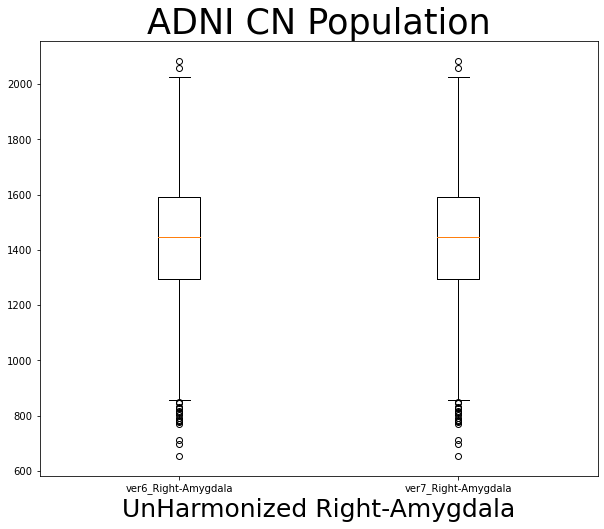

In [17]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged.True_Diagnosis=="CN"]['Right-Amygdala'],df_merged[df_merged.True_Diagnosis=="CN"]['Right-Amygdala']]
labels=["ver6_Right-Amygdala","ver7_Right-Amygdala"]
make_box_plot("ADNI CN Population","UnHarmonized Right-Amygdala",data,labels)

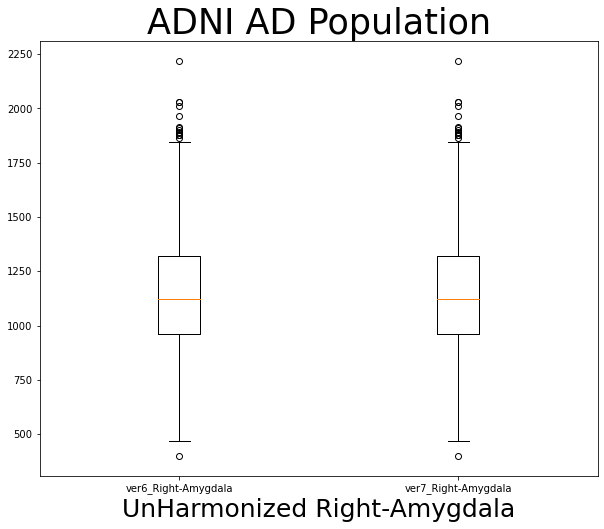

In [18]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged.True_Diagnosis=="AD"]['Right-Amygdala'],df_merged[df_merged.True_Diagnosis=="AD"]['Right-Amygdala']]
labels=["ver6_Right-Amygdala","ver7_Right-Amygdala"]
make_box_plot("ADNI AD Population","UnHarmonized Right-Amygdala",data,labels)

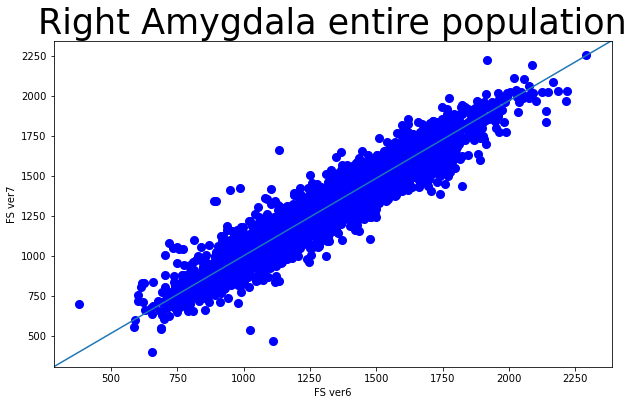

In [19]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df_merged['Right_Amygdala'],df_merged['Right-Amygdala'], c ="blue",linewidths = 2,s = 50)
#plt.scatter(df_merged['Right_Amygdala'],df_merged['Right-Amygdala'], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Right Amygdala entire population",fontsize=35)
plt.show()

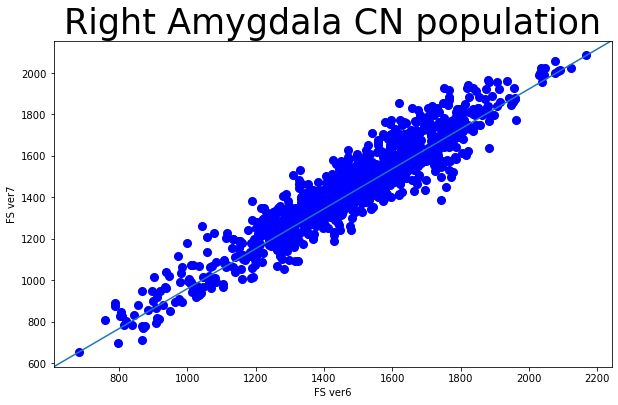

In [20]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df_merged[df_merged.True_Diagnosis=="CN"]['Right_Amygdala'],df_merged[df_merged.True_Diagnosis=="CN"]['Right-Amygdala'], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Right Amygdala CN population",fontsize=35)
plt.show()

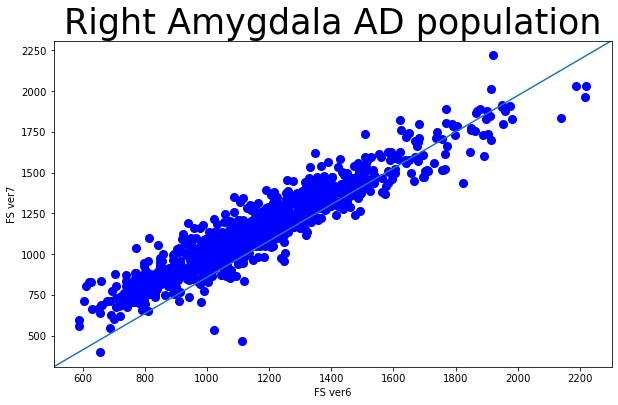

In [21]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df_merged[df_merged.True_Diagnosis=="AD"]['Right_Amygdala'],df_merged[df_merged.True_Diagnosis=="AD"]['Right-Amygdala'], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Right Amygdala AD population",fontsize=35)
plt.show()

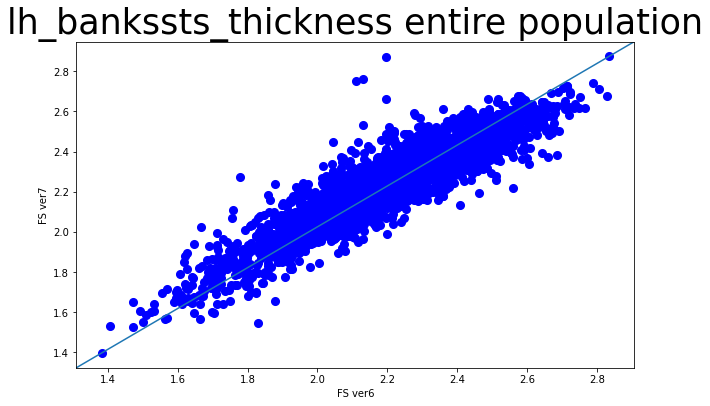

In [22]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df_merged["lh_bankssts_thickness_ver6"],df_merged["lh_bankssts_thickness_ver7"], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("lh_bankssts_thickness entire population",fontsize=35)
plt.show()

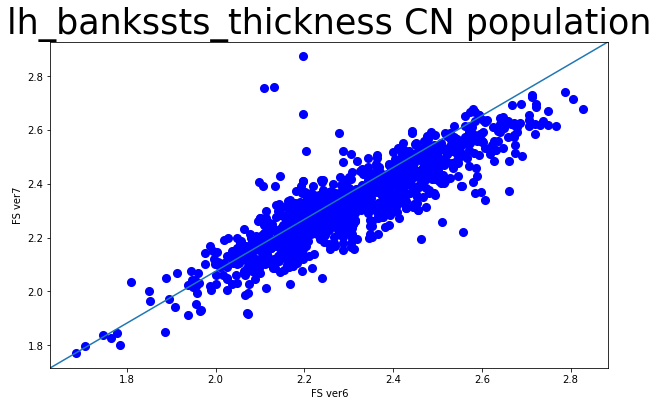

In [23]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df_merged[df_merged.True_Diagnosis=="CN"]["lh_bankssts_thickness_ver6"],df_merged[df_merged.True_Diagnosis=="CN"]["lh_bankssts_thickness_ver7"], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("lh_bankssts_thickness CN population",fontsize=35)
plt.show()

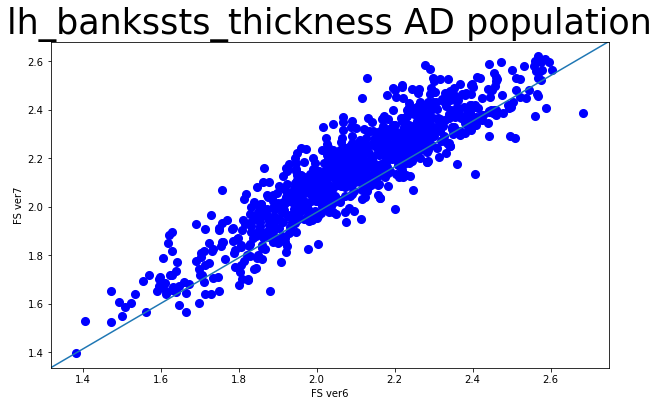

In [24]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df_merged[df_merged.True_Diagnosis=="AD"]["lh_bankssts_thickness_ver6"],df_merged[df_merged.True_Diagnosis=="AD"]["lh_bankssts_thickness_ver7"], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("lh_bankssts_thickness AD population",fontsize=35)
plt.show()

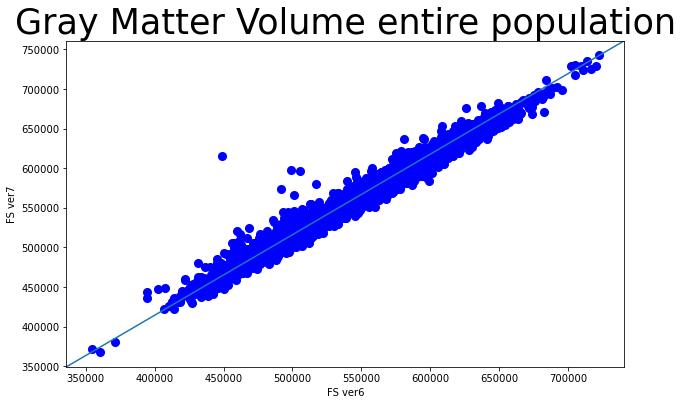

In [25]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df_merged['TotalGrayVol_ver6'],df_merged['TotalGrayVol_ver7'], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Gray Matter Volume entire population",fontsize=35)
plt.show()

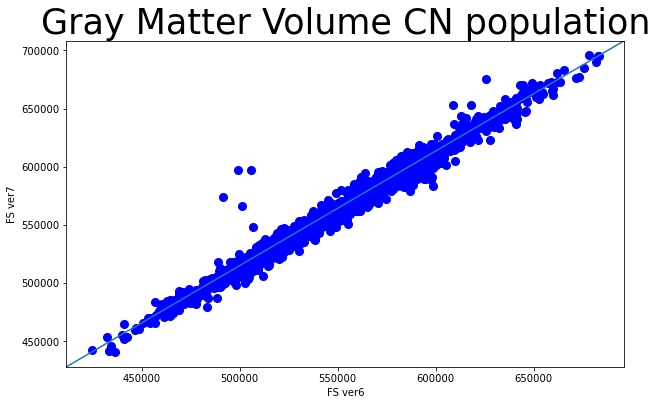

In [26]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver6'],df_merged[df_merged.True_Diagnosis=="CN"]['TotalGrayVol_ver7'], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Gray Matter Volume CN population",fontsize=35)
plt.show()

In [27]:
list(df_merged.columns)

['Subject_ID',
 'Group_ver6',
 'Sex_ver6',
 'Age_ver6',
 'Date_of_Brain_Scan',
 'Scanner_Proxy',
 'lh_bankssts_thickness_ver6',
 'lh_caudalanteriorcingulate_thickness_ver6',
 'lh_caudalmiddlefrontal_thickness_ver6',
 'lh_cuneus_thickness_ver6',
 'lh_entorhinal_thickness_ver6',
 'lh_fusiform_thickness_ver6',
 'lh_inferiorparietal_thickness_ver6',
 'lh_inferiortemporal_thickness_ver6',
 'lh_isthmuscingulate_thickness_ver6',
 'lh_lateraloccipital_thickness_ver6',
 'lh_lateralorbitofrontal_thickness_ver6',
 'lh_lingual_thickness_ver6',
 'lh_medialorbitofrontal_thickness_ver6',
 'lh_middletemporal_thickness_ver6',
 'lh_parahippocampal_thickness_ver6',
 'lh_paracentral_thickness_ver6',
 'lh_parsopercularis_thickness_ver6',
 'lh_parsorbitalis_thickness_ver6',
 'lh_parstriangularis_thickness_ver6',
 'lh_pericalcarine_thickness_ver6',
 'lh_postcentral_thickness_ver6',
 'lh_posteriorcingulate_thickness_ver6',
 'lh_precentral_thickness_ver6',
 'lh_precuneus_thickness_ver6',
 'lh_rostralanteriorci

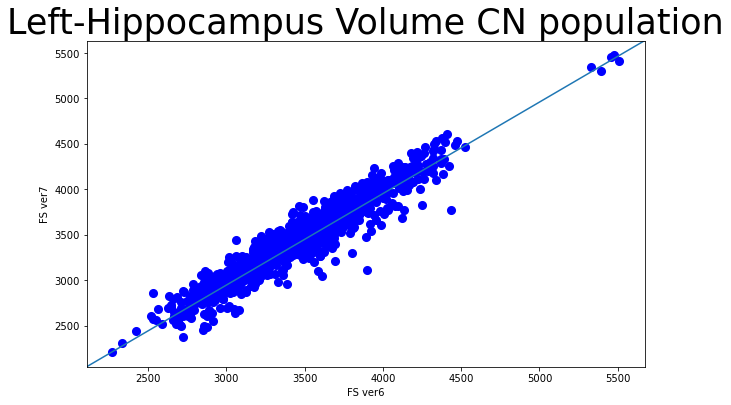

In [28]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df_merged[df_merged.True_Diagnosis=="CN"]['Left-Hippocampus'],df_merged[df_merged.True_Diagnosis=="CN"]['Left_Hippocampus'], c ="blue",linewidths = 2,s = 50)
plt.xlabel("FS ver6")
plt.ylabel("FS ver7")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Left-Hippocampus Volume CN population",fontsize=35)
plt.show()

## our datasets vs azevedo datasets

In [29]:
ukb_df=pd.read_csv(ukb_adni_directory_path+"adni_6_ukb_stacked_may2022.csv")
ukb_df=ukb_df[ukb_df['Dataset']=="UKB"]
ukb_df=ukb_df.reset_index(drop=True)

/ocean/projects/asc170022p/tighu/anaconda/envs/bridges2base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [46]:
#list(ukb_df.columns)

In [31]:
ukb_azevedo_df=pd.read_csv(ukb_adni_directory_path+"ukb_raw_azevedo.csv")
ukb_azevedo_df = ukb_azevedo_df.drop('Unnamed: 0', 1)

In [32]:
ukb_azevedo_df.head(5)

,age,gender,thickness_bankssts_lh,volume_bankssts_lh,thickness_caudalanteriorcingulate_lh,volume_caudalanteriorcingulate_lh,thickness_caudalmiddlefrontal_lh,volume_caudalmiddlefrontal_lh,thickness_cuneus_lh,volume_cuneus_lh,...,volume_Right-Cerebellum-White-Matter,volume_Right-Cerebellum-Cortex,volume_Right-Thalamus-Proper,volume_Right-Caudate,volume_Right-Putamen,volume_Right-Pallidum,volume_Right-Hippocampus,volume_Right-Amygdala,volume_Right-Accumbens-area,eTIV
0,57.0,Female,2.625,3007.0,2.312,1653.0,2.947,7166.0,2.268,3203.0,...,16263.8,63248.2,7563.0,3287.2,4253.8,1846.8,4550.8,1505.2,482.9,9.511455e+05
1,69.0,Female,2.569,2178.0,1.400,672.0,2.799,5907.0,1.897,2489.0,...,12875.8,51946.9,6278.1,3311.3,4721.9,1803.1,3678.6,1221.3,451.6,7.752787e+05
2,70.0,Male,2.445,3060.0,1.920,1140.0,2.743,4984.0,2.135,3606.0,...,13291.6,61731.2,6820.8,3583.4,5223.9,2271.6,4081.8,1592.6,425.5,1.169001e+06
3,63.0,Male,2.243,3219.0,1.763,968.0,2.981,6637.0,2.032,3146.0,...,13178.5,51214.6,6782.1,3366.1,4990.9,2168.4,4129.1,1666.7,430.5,1.217604e+06
4,51.0,Male,2.716,2501.0,2.011,1359.0,2.926,7265.0,2.181,4270.0,...,16727.3,63817.7,8690.6,4312.2,5314.2,2557.1,4861.2,1991.4,624.2,1.218968e+06


In [33]:
ukb_azevedo_df.shape

(37967, 158)

In [34]:
list(ukb_azevedo_df.columns)

['age',
 'gender',
 'thickness_bankssts_lh',
 'volume_bankssts_lh',
 'thickness_caudalanteriorcingulate_lh',
 'volume_caudalanteriorcingulate_lh',
 'thickness_caudalmiddlefrontal_lh',
 'volume_caudalmiddlefrontal_lh',
 'thickness_cuneus_lh',
 'volume_cuneus_lh',
 'thickness_entorhinal_lh',
 'volume_entorhinal_lh',
 'thickness_fusiform_lh',
 'volume_fusiform_lh',
 'thickness_inferiorparietal_lh',
 'volume_inferiorparietal_lh',
 'thickness_inferiortemporal_lh',
 'volume_inferiortemporal_lh',
 'thickness_isthmuscingulate_lh',
 'volume_isthmuscingulate_lh',
 'thickness_lateraloccipital_lh',
 'volume_lateraloccipital_lh',
 'thickness_lateralorbitofrontal_lh',
 'volume_lateralorbitofrontal_lh',
 'thickness_lingual_lh',
 'volume_lingual_lh',
 'thickness_medialorbitofrontal_lh',
 'volume_medialorbitofrontal_lh',
 'thickness_middletemporal_lh',
 'volume_middletemporal_lh',
 'thickness_parahippocampal_lh',
 'volume_parahippocampal_lh',
 'thickness_paracentral_lh',
 'volume_paracentral_lh',
 'thi

In [35]:
adni_train_df=pd.read_csv(ukb_adni_directory_path+"raw_collated_freesurfer.csv",sep="\t")

In [36]:
adni_train_df.head(5)

,subj,diagnosis,age,gender,eTIV,volume_bankssts_lh,thickness_bankssts_lh,volume_caudalanteriorcingulate_lh,thickness_caudalanteriorcingulate_lh,volume_caudalmiddlefrontal_lh,...,volume_Right-WM-hypointensities,volume_non-WM-hypointensities,volume_Left-non-WM-hypointensities,volume_Right-non-WM-hypointensities,volume_Optic-Chiasm,volume_CC_Posterior,volume_CC_Mid_Posterior,volume_CC_Central,volume_CC_Mid_Anterior,volume_CC_Anterior
0,sub-002-S-0295,Control,84.8,Male,1.642845e+06,2157,2.488,1439,2.473,6104,...,0,0.0,0,0,209.6,1206.9,559.9,458.5,416.6,842.7
1,sub-002-S-0413,Control,76.3,Female,1.603248e+06,1983,2.624,1704,2.559,5923,...,0,0.0,0,0,207.1,942.2,399.4,399.5,417.9,813.6
2,sub-002-S-0559,Control,79.3,Male,1.712183e+06,2463,2.281,1932,2.659,5336,...,0,0.0,0,0,300.2,1029.1,498.3,403.5,457.8,1022.0
3,sub-002-S-0619,AD,77.5,Male,2.071259e+06,2429,2.133,1585,1.749,3861,...,0,1.0,0,0,220.4,943.4,350.1,272.9,244.2,787.9
4,sub-002-S-0685,Control,89.6,Female,1.532201e+06,1311,2.289,2067,2.974,5355,...,0,0.0,0,0,186.2,968.1,423.7,430.7,447.9,936.7


In [37]:
adni_train_df['diagnosis'].unique()

array(['Control', 'AD'], dtype=object)

In [56]:
list(adni_train_df.columns)

['subj',
 'diagnosis',
 'age',
 'gender',
 'eTIV',
 'volume_bankssts_lh',
 'thickness_bankssts_lh',
 'volume_caudalanteriorcingulate_lh',
 'thickness_caudalanteriorcingulate_lh',
 'volume_caudalmiddlefrontal_lh',
 'thickness_caudalmiddlefrontal_lh',
 'volume_cuneus_lh',
 'thickness_cuneus_lh',
 'volume_entorhinal_lh',
 'thickness_entorhinal_lh',
 'volume_fusiform_lh',
 'thickness_fusiform_lh',
 'volume_inferiorparietal_lh',
 'thickness_inferiorparietal_lh',
 'volume_inferiortemporal_lh',
 'thickness_inferiortemporal_lh',
 'volume_isthmuscingulate_lh',
 'thickness_isthmuscingulate_lh',
 'volume_lateraloccipital_lh',
 'thickness_lateraloccipital_lh',
 'volume_lateralorbitofrontal_lh',
 'thickness_lateralorbitofrontal_lh',
 'volume_lingual_lh',
 'thickness_lingual_lh',
 'volume_medialorbitofrontal_lh',
 'thickness_medialorbitofrontal_lh',
 'volume_middletemporal_lh',
 'thickness_middletemporal_lh',
 'volume_parahippocampal_lh',
 'thickness_parahippocampal_lh',
 'volume_paracentral_lh',
 '

In [41]:
adni_train_df.diagnosis.unique()

array(['Control', 'AD'], dtype=object)

In [49]:
list(adni_train_df.columns)

['subj',
 'diagnosis',
 'age',
 'gender',
 'eTIV',
 'volume_bankssts_lh',
 'thickness_bankssts_lh',
 'volume_caudalanteriorcingulate_lh',
 'thickness_caudalanteriorcingulate_lh',
 'volume_caudalmiddlefrontal_lh',
 'thickness_caudalmiddlefrontal_lh',
 'volume_cuneus_lh',
 'thickness_cuneus_lh',
 'volume_entorhinal_lh',
 'thickness_entorhinal_lh',
 'volume_fusiform_lh',
 'thickness_fusiform_lh',
 'volume_inferiorparietal_lh',
 'thickness_inferiorparietal_lh',
 'volume_inferiortemporal_lh',
 'thickness_inferiortemporal_lh',
 'volume_isthmuscingulate_lh',
 'thickness_isthmuscingulate_lh',
 'volume_lateraloccipital_lh',
 'thickness_lateraloccipital_lh',
 'volume_lateralorbitofrontal_lh',
 'thickness_lateralorbitofrontal_lh',
 'volume_lingual_lh',
 'thickness_lingual_lh',
 'volume_medialorbitofrontal_lh',
 'thickness_medialorbitofrontal_lh',
 'volume_middletemporal_lh',
 'thickness_middletemporal_lh',
 'volume_parahippocampal_lh',
 'thickness_parahippocampal_lh',
 'volume_paracentral_lh',
 '

In [48]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged["True_Diagnosis"]=="CN"]['TotalGrayVol_ver6'],df_merged[df_merged["True_Diagnosis"]=="CN"]['TotalGrayVol_ver7'],
      adni_train_df[adni_train_df.diagnosis=="Control"]["TotalGrayVol"],ukb_df["TotalGrayVol"]] 
labels=["ver6_ADNI","ver7_ADNI","Azevedo_adni","Azevedo_ukb","our_UKB"]
make_box_plot("CN Population TotalGrayVol ","TotalGrayVol",data,labels)

KeyError: 'TotalGrayVol'

<Figure size 720x576 with 0 Axes>

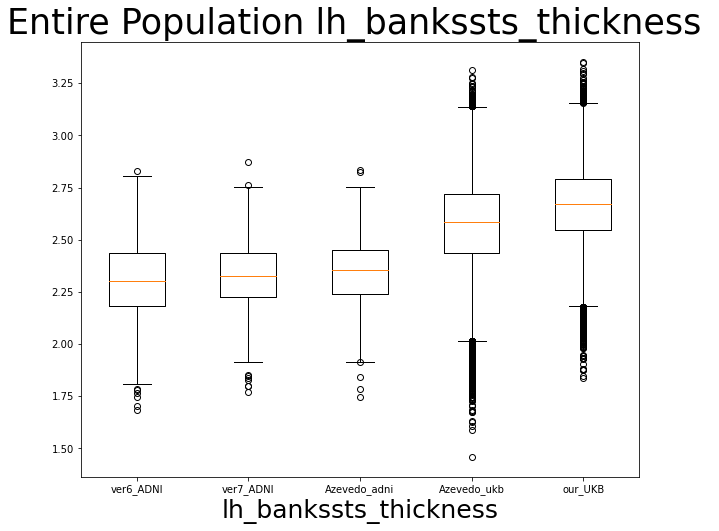

In [50]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged["True_Diagnosis"]=="CN"]['lh_bankssts_thickness_ver6'],df_merged[df_merged["True_Diagnosis"]=="CN"]['lh_bankssts_thickness_ver7'],
      adni_train_df[adni_train_df.diagnosis=="Control"]["thickness_bankssts_lh"],ukb_azevedo_df["thickness_bankssts_lh"],ukb_df["lh_bankssts_thickness"]] 
labels=["ver6_ADNI","ver7_ADNI","Azevedo_adni","Azevedo_ukb","our_UKB"]
make_box_plot("Entire Population lh_bankssts_thickness ","lh_bankssts_thickness",data,labels)

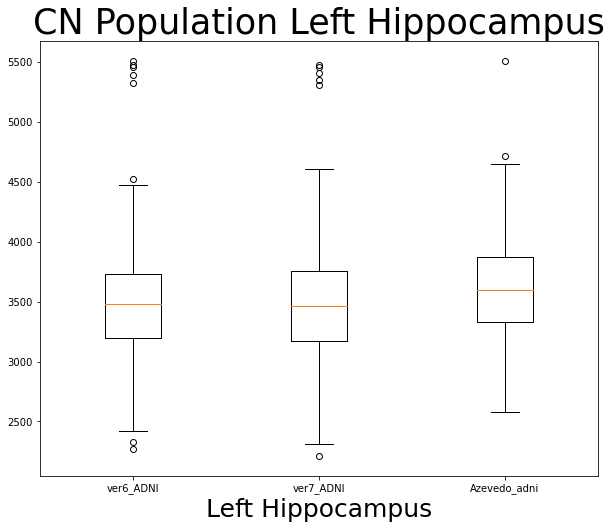

In [53]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged["True_Diagnosis"]=="CN"]['Left-Hippocampus'],df_merged[df_merged["True_Diagnosis"]=="CN"]['Left_Hippocampus'],
      adni_train_df[adni_train_df.diagnosis=="Control"]["volume_Left-Hippocampus"]]
labels=["ver6_ADNI","ver7_ADNI","Azevedo_adni"]
make_box_plot("CN Population Left Hippocampus","Left Hippocampus",data,labels)

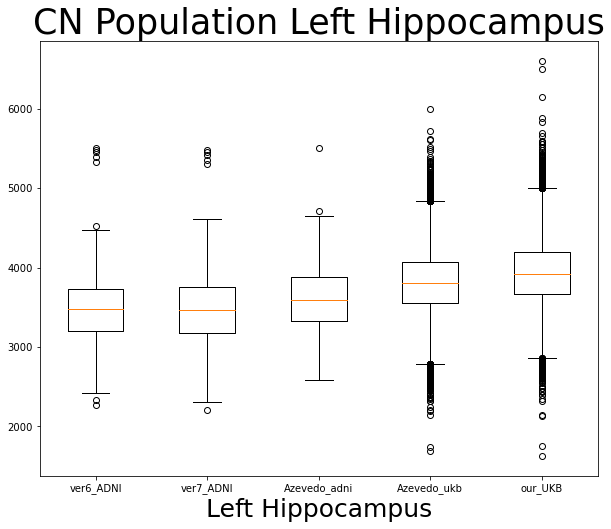

In [52]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged["True_Diagnosis"]=="CN"]['Left-Hippocampus'],df_merged[df_merged["True_Diagnosis"]=="CN"]['Left_Hippocampus'],
      adni_train_df[adni_train_df.diagnosis=="Control"]["volume_Left-Hippocampus"],ukb_azevedo_df["volume_Left-Hippocampus"],ukb_df["Left-Hippocampus"]]
labels=["ver6_ADNI","ver7_ADNI","Azevedo_adni","Azevedo_ukb","our_UKB"]
make_box_plot("CN Population Left Hippocampus","Left Hippocampus",data,labels)

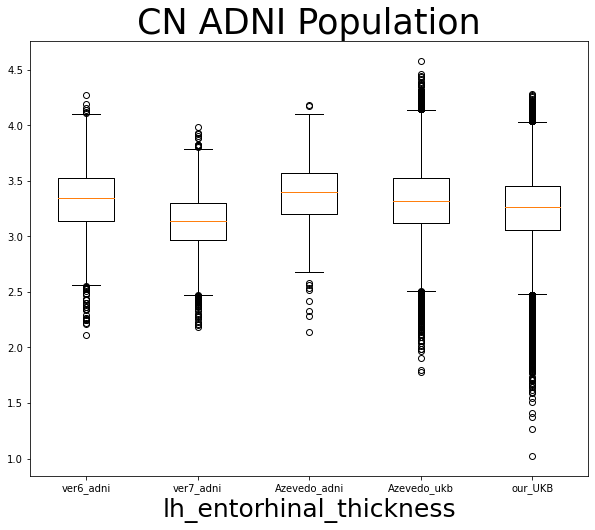

In [54]:
fig = plt.figure(figsize =(10, 8))
data=[df_merged[df_merged["True_Diagnosis"]=="CN"]['lh_entorhinal_thickness_ver6'],df_merged[df_merged["True_Diagnosis"]=="CN"]['lh_entorhinal_thickness_ver7'],
      adni_train_df[adni_train_df.diagnosis=="Control"]["thickness_entorhinal_lh"],ukb_azevedo_df["thickness_entorhinal_lh"],ukb_df["lh_entorhinal_thickness"]] 
labels=["ver6_adni","ver7_adni","Azevedo_adni","Azevedo_ukb","our_UKB"]
make_box_plot("CN ADNI Population","lh_entorhinal_thickness",data,labels)

## Classification Model: to predict Group using Harmonized and Unharmonized features

In [59]:
import pandas as pd
ukb_adni_directory_path="/ocean/projects/asc170022p/tighu/ADNI_UKB_Harmonization_May_2022/"


unharmonized_df = pd.read_csv(ukb_adni_directory_path+"adni_6_ukb_stacked_may2022.csv")
harmonized_df = pd.read_csv(ukb_adni_directory_path+"harmonized_adni6_ukb_May2022.csv") 
harmonized_df = harmonized_df.drop('Unnamed: 0', 1)

/ocean/projects/asc170022p/tighu/anaconda/envs/bridges2base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/ocean/projects/asc170022p/tighu/anaconda/envs/bridges2base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [60]:
features_un = list(unharmonized_df.columns[6:-1])

In [61]:
len(features_un)

135

In [62]:
harmonized_df.columns

Index(['data_combat.Subject_ID', 'data_combat.Date_of_Brain_Scan',
       'data_combat.Scanner_Proxy', 'data_combat.lh_bankssts_thickness.combat',
       'data_combat.lh_caudalanteriorcingulate_thickness.combat',
       'data_combat.lh_caudalmiddlefrontal_thickness.combat',
       'data_combat.lh_cuneus_thickness.combat',
       'data_combat.lh_entorhinal_thickness.combat',
       'data_combat.lh_fusiform_thickness.combat',
       'data_combat.lh_inferiorparietal_thickness.combat',
       ...
       'data_combat.CerebralWhiteMatterVol.combat',
       'data_combat.SubCortGrayVol.combat', 'data_combat.TotalGrayVol.combat',
       'data_combat.SupraTentorialVol.combat',
       'data_combat.SupraTentorialVolNotVent.combat',
       'data_combat.SupraTentorialVolNotVentVox.combat',
       'data_combat.MaskVol.combat', 'data_combat.BrainSegVol.to.eTIV.combat',
       'data_combat.MaskVol.to.eTIV.combat',
       'data_combat.EstimatedTotalIntraCranialVol.combat'],
      dtype='object', length=

In [63]:
unharmonized_df[unharmonized_df.Dataset=="ADNI"].head(5)

,Subject_ID,Group,Sex,Age,Date_of_Brain_Scan,Scanner_Proxy,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,...,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,EstimatedTotalIntraCranialVol,Dataset
33051,941_S_1202,CN,M,79,2/28/08,1.5T 127,2.213,2.742,2.166,1.601,...,47198,584831.032923,980536.048905,921732.048905,920361,1706490,0.669005,1.005916,1.696454e+06,ADNI
33052,941_S_1202,MCI,M,81,3/14/10,1.5T 127,2.221,2.795,2.187,1.612,...,45742,571209.385403,960138.187242,895109.187242,893961,1684032,0.655583,0.994114,1.694003e+06,ADNI
33053,941_S_1202,MCI,M,80,2/17/09,1.5T 127,2.261,2.867,2.197,1.660,...,47677,586531.610070,972753.266808,913204.266808,911990,1696986,0.662757,0.999413,1.697982e+06,ADNI
33054,941_S_1202,CN,M,78,1/30/07,1.5T 127,2.313,2.682,2.296,1.626,...,48095,605580.853911,998516.312635,941458.312635,940083,1692298,0.679679,0.996779,1.697767e+06,ADNI
33055,941_S_1202,CN,M,78,8/24/07,1.5T 127,2.425,2.761,2.240,1.668,...,48354,598590.707086,977718.658583,920246.658583,918948,1672620,0.670407,0.990049,1.689432e+06,ADNI


In [64]:
unharmonized_df=unharmonized_df[unharmonized_df['Dataset']=="ADNI"]

In [65]:
def get_true_diagnosis(row):
    subject_id,date_of_scan,scanner = row["Subject_ID"],row["Date_of_Brain_Scan"],row["Scanner_Proxy"]
    return temp_df[(temp_df.Subject_ID==subject_id) & (temp_df.Date_of_Brain_Scan==date_of_scan) & (temp_df.Scanner_Proxy==scanner)]["True Diagnosis"].values[0]
unharmonized_df["True_Diagnosis"]=unharmonized_df.apply(lambda x: get_true_diagnosis(x),axis=1)

In [66]:
unharmonized_df['True_Diagnosis'].value_counts()

MCI    1428
CN     1077
AD      960
Name: True_Diagnosis, dtype: int64

In [67]:
harmonized_df.shape

(36516, 131)

In [68]:
unharmonized_df.shape

(3465, 143)

In [69]:
final_harmonized_df=pd.merge(harmonized_df,unharmonized_df,left_on=['data_combat.Subject_ID','data_combat.Date_of_Brain_Scan','data_combat.Scanner_Proxy'], right_on = ['Subject_ID','Date_of_Brain_Scan','Scanner_Proxy'], how='left')

In [70]:
final_harmonized_df.shape

(36516, 274)

In [71]:
final_harmonized_df=final_harmonized_df.dropna()

In [72]:
unharmonized_df.shape

(3465, 143)

In [73]:
unharmonized_df.to_csv("adni_freesurfer6_unharmonized.csv",index=False)

In [74]:
list(final_harmonized_df.columns)

['data_combat.Subject_ID',
 'data_combat.Date_of_Brain_Scan',
 'data_combat.Scanner_Proxy',
 'data_combat.lh_bankssts_thickness.combat',
 'data_combat.lh_caudalanteriorcingulate_thickness.combat',
 'data_combat.lh_caudalmiddlefrontal_thickness.combat',
 'data_combat.lh_cuneus_thickness.combat',
 'data_combat.lh_entorhinal_thickness.combat',
 'data_combat.lh_fusiform_thickness.combat',
 'data_combat.lh_inferiorparietal_thickness.combat',
 'data_combat.lh_inferiortemporal_thickness.combat',
 'data_combat.lh_isthmuscingulate_thickness.combat',
 'data_combat.lh_lateraloccipital_thickness.combat',
 'data_combat.lh_lateralorbitofrontal_thickness.combat',
 'data_combat.lh_lingual_thickness.combat',
 'data_combat.lh_medialorbitofrontal_thickness.combat',
 'data_combat.lh_middletemporal_thickness.combat',
 'data_combat.lh_parahippocampal_thickness.combat',
 'data_combat.lh_paracentral_thickness.combat',
 'data_combat.lh_parsopercularis_thickness.combat',
 'data_combat.lh_parsorbitalis_thickness

In [75]:
final_harmonized_df=final_harmonized_df.drop(columns=list(final_harmonized_df.columns)[131:-1])

In [76]:
final_harmonized_df['True_Diagnosis'].value_counts()

MCI    1428
CN     1077
AD      960
Name: True_Diagnosis, dtype: int64

In [77]:
len(list(unharmonized_df.columns))

143

In [78]:
features_hm = list(final_harmonized_df.columns)[3:-1]

In [79]:
X_ha, y_ha = final_harmonized_df[features_hm].values, (final_harmonized_df['True_Diagnosis']=="AD").values.astype(int)
X_uh, y_uh = unharmonized_df[features_un].values, (unharmonized_df['True_Diagnosis']=="AD").values.astype(int)

In [80]:
models={

       'Random Forest':RandomForestClassifier(n_estimators=20,random_state=1)}


scores={'roc_auc':roc_auc_score,}
aurocs={'uh':[],'ha':[]}
eces={'uh':[],'ha':[]}

n_folds=20
for fold in range(n_folds):
    print('fold', fold)
    
    ###########Prep Data##########
    train_scanners, test_scanners = train_test_split(unharmonized_df['Scanner_Proxy'].unique(), random_state=fold)
    
    train_df_uh=unharmonized_df[unharmonized_df.Scanner_Proxy.isin(train_scanners)]
    test_df_uh=unharmonized_df[unharmonized_df.Scanner_Proxy.isin(test_scanners)]
    
    train_df_ha=final_harmonized_df[final_harmonized_df["data_combat.Scanner_Proxy"].isin(train_scanners)]
    test_df_ha=final_harmonized_df[final_harmonized_df["data_combat.Scanner_Proxy"].isin(test_scanners)]
    
    print('train df shape:',train_df_uh.shape, train_df_ha.shape)
    print('test df shape:',test_df_uh.shape, test_df_ha.shape)
    
    X_train_uh=train_df_uh[features_un].values
    y_train_uh=(train_df_uh['True_Diagnosis']=='AD').values.astype(int)
    
    X_train_ha=train_df_ha[features_hm].values
    y_train_ha=(train_df_ha['True_Diagnosis']=='AD').values.astype(int)
    
    X_test_uh=test_df_uh[features_un].values
    y_test_uh=(test_df_uh['True_Diagnosis']=='AD').values.astype(int)
    
    X_test_ha=test_df_ha[features_hm].values
    y_test_ha=(test_df_ha['True_Diagnosis']=='AD').values.astype(int)

    ##############################   
    for m_name in models: 
        model=models[m_name]
        reg=model.fit(X_train_uh,y_train_uh)
        for score in scores:
            metric=scores[score]
            met=metric(y_test_uh,reg.predict_proba(X_test_uh)[:,1])
            aurocs['uh'].append(met)
#             print('\t\t',score,met)
        ece=cal.get_ece(reg.predict_proba(X_test_uh)[:,1], y_test_uh)
#         print('\t\tECE:',ece)
        eces['uh'].append(ece)

        #EB
#         print('\tEB:')
        reg=model.fit(X_train_ha,y_train_ha)
        for score in scores:
            metric=scores[score]
            met=metric(y_test_ha,reg.predict_proba(X_test_ha)[:,1])
            aurocs['ha'].append(met)
#             print('\t\t',score,met)

        ece=cal.get_ece(reg.predict_proba(X_test_ha)[:,1], y_test_ha)
        eces['ha'].append(ece)
#         print('\t\tECE:',ece)

fold 0
train df shape: (2443, 143) (2443, 132)
test df shape: (1022, 143) (1022, 132)
fold 1
train df shape: (2482, 143) (2482, 132)
test df shape: (983, 143) (983, 132)
fold 2
train df shape: (2675, 143) (2675, 132)
test df shape: (790, 143) (790, 132)
fold 3
train df shape: (2651, 143) (2651, 132)
test df shape: (814, 143) (814, 132)
fold 4
train df shape: (2519, 143) (2519, 132)
test df shape: (946, 143) (946, 132)
fold 5
train df shape: (2674, 143) (2674, 132)
test df shape: (791, 143) (791, 132)
fold 6
train df shape: (2763, 143) (2763, 132)
test df shape: (702, 143) (702, 132)
fold 7
train df shape: (2407, 143) (2407, 132)
test df shape: (1058, 143) (1058, 132)
fold 8
train df shape: (2427, 143) (2427, 132)
test df shape: (1038, 143) (1038, 132)
fold 9
train df shape: (2587, 143) (2587, 132)
test df shape: (878, 143) (878, 132)
fold 10
train df shape: (2769, 143) (2769, 132)
test df shape: (696, 143) (696, 132)
fold 11
train df shape: (2562, 143) (2562, 132)
test df shape: (903, 

In [81]:
print("ECE:")
for k in eces.keys():
    print("\t"+k,round(np.mean(eces[k]),4),'('+str(round(np.std(eces[k]),4))+')')
print("AUROC:")
for k in aurocs.keys():
    print("\t"+k,round(np.mean(aurocs[k]),4), '('+str(round(np.std(aurocs[k]),4))+')')

ECE:
	uh 0.0478 (0.0137)
	ha 0.0492 (0.0122)
AUROC:
	uh 0.8405 (0.0226)
	ha 0.8371 (0.0218)


## Regression Modelling on Age

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
unharmonized_df.head(5)

,Subject_ID,Group,Sex,Age,Date_of_Brain_Scan,Scanner_Proxy,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,...,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,EstimatedTotalIntraCranialVol,Dataset,True_Diagnosis
33051,941_S_1202,CN,M,79,2/28/08,1.5T 127,2.213,2.742,2.166,1.601,...,584831.032923,980536.048905,921732.048905,920361,1706490,0.669005,1.005916,1.696454e+06,ADNI,CN
33052,941_S_1202,MCI,M,81,3/14/10,1.5T 127,2.221,2.795,2.187,1.612,...,571209.385403,960138.187242,895109.187242,893961,1684032,0.655583,0.994114,1.694003e+06,ADNI,MCI
33053,941_S_1202,MCI,M,80,2/17/09,1.5T 127,2.261,2.867,2.197,1.660,...,586531.610070,972753.266808,913204.266808,911990,1696986,0.662757,0.999413,1.697982e+06,ADNI,MCI
33054,941_S_1202,CN,M,78,1/30/07,1.5T 127,2.313,2.682,2.296,1.626,...,605580.853911,998516.312635,941458.312635,940083,1692298,0.679679,0.996779,1.697767e+06,ADNI,CN
33055,941_S_1202,CN,M,78,8/24/07,1.5T 127,2.425,2.761,2.240,1.668,...,598590.707086,977718.658583,920246.658583,918948,1672620,0.670407,0.990049,1.689432e+06,ADNI,CN


In [83]:
x_train, x_val, y_train, y_val = train_test_split(unharmonized_df[features_un],unharmonized_df['Age'],test_size=0.2,random_state=1)     

In [84]:
reg_model = RandomForestRegressor(random_state=0,n_estimators=200)
reg_model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=0)

In [85]:
metrics.mean_absolute_error(y_val, reg_model.predict(x_val))

2.94478354978355

In [86]:
metrics.r2_score(y_val, reg_model.predict(x_val))

0.6769283086894591

In [87]:
res=reg_model.predict(x_val)

In [88]:
#y_val.values

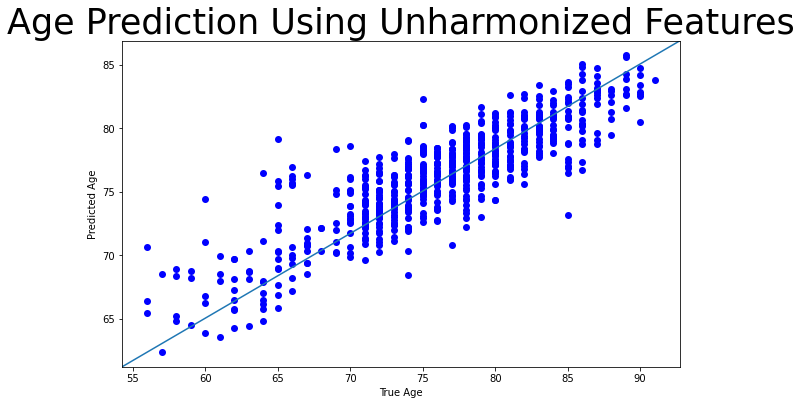

In [89]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(y_val,res, c ="blue",linewidths = 2,s = 25)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Age Prediction Using Unharmonized Features",fontsize=35)
plt.show()

In [90]:
final_harmonized_df=pd.merge(harmonized_df,unharmonized_df,left_on=['data_combat.Subject_ID','data_combat.Date_of_Brain_Scan','data_combat.Scanner_Proxy'], right_on = ['Subject_ID','Date_of_Brain_Scan','Scanner_Proxy'], how='left')
final_harmonized_df=final_harmonized_df.dropna()

In [91]:
list(final_harmonized_df.columns)[131:134]+list(final_harmonized_df.columns)[135:-1]

['Subject_ID',
 'Group',
 'Sex',
 'Date_of_Brain_Scan',
 'Scanner_Proxy',
 'lh_bankssts_thickness',
 'lh_caudalanteriorcingulate_thickness',
 'lh_caudalmiddlefrontal_thickness',
 'lh_cuneus_thickness',
 'lh_entorhinal_thickness',
 'lh_fusiform_thickness',
 'lh_inferiorparietal_thickness',
 'lh_inferiortemporal_thickness',
 'lh_isthmuscingulate_thickness',
 'lh_lateraloccipital_thickness',
 'lh_lateralorbitofrontal_thickness',
 'lh_lingual_thickness',
 'lh_medialorbitofrontal_thickness',
 'lh_middletemporal_thickness',
 'lh_parahippocampal_thickness',
 'lh_paracentral_thickness',
 'lh_parsopercularis_thickness',
 'lh_parsorbitalis_thickness',
 'lh_parstriangularis_thickness',
 'lh_pericalcarine_thickness',
 'lh_postcentral_thickness',
 'lh_posteriorcingulate_thickness',
 'lh_precentral_thickness',
 'lh_precuneus_thickness',
 'lh_rostralanteriorcingulate_thickness',
 'lh_rostralmiddlefrontal_thickness',
 'lh_superiorfrontal_thickness',
 'lh_superiorparietal_thickness',
 'lh_superiortempo

In [92]:
final_harmonized_df=final_harmonized_df.drop(columns=list(final_harmonized_df.columns)[131:134]+list(final_harmonized_df.columns)[135:-1])

In [93]:
final_harmonized_df.head(5)

,data_combat.Subject_ID,data_combat.Date_of_Brain_Scan,data_combat.Scanner_Proxy,data_combat.lh_bankssts_thickness.combat,data_combat.lh_caudalanteriorcingulate_thickness.combat,data_combat.lh_caudalmiddlefrontal_thickness.combat,data_combat.lh_cuneus_thickness.combat,data_combat.lh_entorhinal_thickness.combat,data_combat.lh_fusiform_thickness.combat,data_combat.lh_inferiorparietal_thickness.combat,...,data_combat.TotalGrayVol.combat,data_combat.SupraTentorialVol.combat,data_combat.SupraTentorialVolNotVent.combat,data_combat.SupraTentorialVolNotVentVox.combat,data_combat.MaskVol.combat,data_combat.BrainSegVol.to.eTIV.combat,data_combat.MaskVol.to.eTIV.combat,data_combat.EstimatedTotalIntraCranialVol.combat,Age,True_Diagnosis
33051,941_S_1202,2/28/08,1.5T 127,2.555006,2.618131,2.628698,1.801358,2.302280,2.718964,2.725314,...,684556.429725,1.093895e+06,1.043832e+06,1.040772e+06,1.783985e+06,0.749682,1.055251,1.694933e+06,79.0,CN
33052,941_S_1202,3/14/10,1.5T 127,2.601526,2.734782,2.690950,1.824981,2.065322,2.751044,2.655999,...,668914.611343,1.065808e+06,1.008759e+06,1.004784e+06,1.749369e+06,0.732259,1.039449,1.689378e+06,81.0,MCI
33053,941_S_1202,2/17/09,1.5T 127,2.657113,2.871329,2.702542,1.907668,2.521255,2.759440,2.672014,...,692660.070159,1.084178e+06,1.034688e+06,1.032141e+06,1.769413e+06,0.744999,1.048212,1.696595e+06,80.0,MCI
33054,941_S_1202,1/30/07,1.5T 127,2.696621,2.498091,2.808127,1.843896,2.497601,2.700051,2.766313,...,717253.234606,1.120878e+06,1.072295e+06,1.070942e+06,1.757252e+06,0.769241,1.038382,1.695808e+06,78.0,CN
33055,941_S_1202,8/24/07,1.5T 127,2.857206,2.651654,2.729803,1.917213,2.085271,2.690949,2.794074,...,705724.885854,1.087494e+06,1.039332e+06,1.035834e+06,1.723345e+06,0.751176,1.026433,1.675991e+06,78.0,CN


In [94]:
features_hm

['data_combat.lh_bankssts_thickness.combat',
 'data_combat.lh_caudalanteriorcingulate_thickness.combat',
 'data_combat.lh_caudalmiddlefrontal_thickness.combat',
 'data_combat.lh_cuneus_thickness.combat',
 'data_combat.lh_entorhinal_thickness.combat',
 'data_combat.lh_fusiform_thickness.combat',
 'data_combat.lh_inferiorparietal_thickness.combat',
 'data_combat.lh_inferiortemporal_thickness.combat',
 'data_combat.lh_isthmuscingulate_thickness.combat',
 'data_combat.lh_lateraloccipital_thickness.combat',
 'data_combat.lh_lateralorbitofrontal_thickness.combat',
 'data_combat.lh_lingual_thickness.combat',
 'data_combat.lh_medialorbitofrontal_thickness.combat',
 'data_combat.lh_middletemporal_thickness.combat',
 'data_combat.lh_parahippocampal_thickness.combat',
 'data_combat.lh_paracentral_thickness.combat',
 'data_combat.lh_parsopercularis_thickness.combat',
 'data_combat.lh_parsorbitalis_thickness.combat',
 'data_combat.lh_parstriangularis_thickness.combat',
 'data_combat.lh_pericalcarin

In [95]:
x_train, x_val, y_train, y_val = train_test_split(final_harmonized_df[features_hm],final_harmonized_df['Age'],test_size=0.2,random_state=1) 

In [96]:
reg_model = RandomForestRegressor(random_state=1)
reg_model.fit(x_train, y_train)

RandomForestRegressor(random_state=1)

In [97]:
metrics.mean_absolute_error(y_val, reg_model.predict(x_val))

3.4097113997114

In [98]:
metrics.r2_score(y_val, reg_model.predict(x_val))

0.5862018218478153

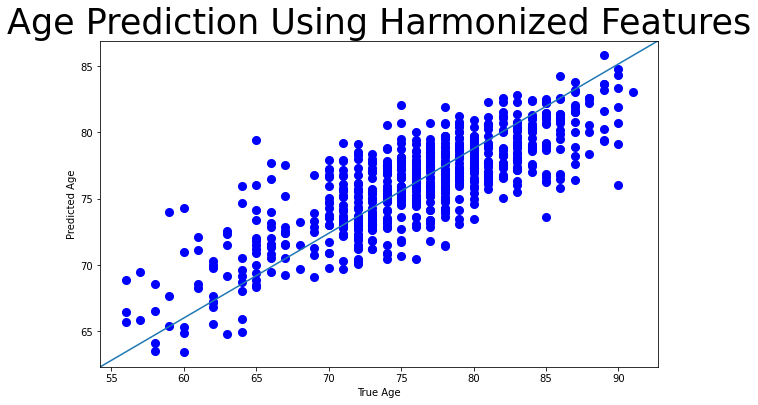

In [99]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(y_val,reg_model.predict(x_val), c ="blue",linewidths = 2,s = 50)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
plt.title("Age Prediction Using Harmonized Features",fontsize=35)
plt.show()

## Training Classifier on Harmonized ADNI & Prediction on UKB

In [100]:
clf_har = RandomForestClassifier(random_state=0,n_estimators=500,verbose=1)

In [101]:
train_scanners, test_scanners = train_test_split(unharmonized_df['Scanner_Proxy'].unique(), random_state=fold)

train_df_ha = final_harmonized_df[final_harmonized_df["data_combat.Scanner_Proxy"].isin(train_scanners)]
test_df_ha = final_harmonized_df[final_harmonized_df["data_combat.Scanner_Proxy"].isin(test_scanners)]

X_train_ha=train_df_ha[features_hm].values
y_train_ha=(train_df_ha['True_Diagnosis']=='AD').values.astype(int)
    
X_test_ha=test_df_ha[features_hm].values
y_test_ha=(test_df_ha['True_Diagnosis']=='AD').values.astype(int)


In [102]:
clf_har.fit(X_train_ha,y_train_ha)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.1s finished


RandomForestClassifier(n_estimators=500, random_state=0, verbose=1)

In [103]:
harmonized_df = pd.read_csv(ukb_adni_directory_path+"harmonized_adni6_ukb_May2022.csv") 
harmonized_df = harmonized_df.drop('Unnamed: 0', 1)

/ocean/projects/asc170022p/tighu/anaconda/envs/bridges2base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [104]:
unharmonized_df = pd.read_csv(ukb_adni_directory_path+"adni_6_ukb_stacked_may2022.csv")

/ocean/projects/asc170022p/tighu/anaconda/envs/bridges2base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [105]:
merged_df=pd.merge(harmonized_df,unharmonized_df,left_on=['data_combat.Subject_ID','data_combat.Date_of_Brain_Scan','data_combat.Scanner_Proxy'], right_on = ['Subject_ID','Date_of_Brain_Scan','Scanner_Proxy'], how='left')


In [106]:
merged_df.head(5)

,data_combat.Subject_ID,data_combat.Date_of_Brain_Scan,data_combat.Scanner_Proxy,data_combat.lh_bankssts_thickness.combat,data_combat.lh_caudalanteriorcingulate_thickness.combat,data_combat.lh_caudalmiddlefrontal_thickness.combat,data_combat.lh_cuneus_thickness.combat,data_combat.lh_entorhinal_thickness.combat,data_combat.lh_fusiform_thickness.combat,data_combat.lh_inferiorparietal_thickness.combat,...,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,SupraTentorialVolNotVent,SupraTentorialVolNotVentVox,MaskVol,BrainSegVol-to-eTIV,MaskVol-to-eTIV,EstimatedTotalIntraCranialVol,Dataset
0,1000295,2017-10-27,Newcastle,2.296284,1.178939,2.276881,2.015306,3.044882,2.892787,2.501170,...,74024,818307.374370,1.388836e+06,1.351159e+06,1348707,1988305,0.904154,1.135316,1.751323e+06,UKB
1,1000397,2018-03-07,Newcastle,2.500101,2.969933,2.990356,1.886608,3.656489,2.944818,2.794912,...,53103,645218.597035,1.042441e+06,1.000121e+06,995239,1555091,0.783897,1.033555,1.504604e+06,UKB
2,1000432,2018-07-14,Cheadle,2.734754,3.305112,2.774210,1.966005,3.201053,2.943196,2.642145,...,55982,678619.948762,1.095522e+06,1.069967e+06,1065284,1617026,0.831715,1.077098,1.501280e+06,UKB
3,1000591,2019-07-09,Reading,2.779423,2.344385,3.093786,2.079017,3.275997,3.038995,2.591875,...,64072,762356.497882,1.213087e+06,1.187227e+06,1183537,1842042,0.803061,1.074893,1.713697e+06,UKB
4,1000882,2017-11-16,Cheadle,2.448656,2.768825,2.991334,1.804743,3.340516,2.790543,2.651284,...,66041,749467.819722,1.298545e+06,1.271570e+06,1265770,1862677,0.795217,1.013020,1.838737e+06,UKB


In [107]:
ukb_df=merged_df[merged_df['Dataset']=="UKB"]

In [108]:
ukb_df.columns

Index(['data_combat.Subject_ID', 'data_combat.Date_of_Brain_Scan',
       'data_combat.Scanner_Proxy', 'data_combat.lh_bankssts_thickness.combat',
       'data_combat.lh_caudalanteriorcingulate_thickness.combat',
       'data_combat.lh_caudalmiddlefrontal_thickness.combat',
       'data_combat.lh_cuneus_thickness.combat',
       'data_combat.lh_entorhinal_thickness.combat',
       'data_combat.lh_fusiform_thickness.combat',
       'data_combat.lh_inferiorparietal_thickness.combat',
       ...
       'SubCortGrayVol', 'TotalGrayVol', 'SupraTentorialVol',
       'SupraTentorialVolNotVent', 'SupraTentorialVolNotVentVox', 'MaskVol',
       'BrainSegVol-to-eTIV', 'MaskVol-to-eTIV',
       'EstimatedTotalIntraCranialVol', 'Dataset'],
      dtype='object', length=273)

In [109]:
ukb_df=ukb_df.drop(columns=list(ukb_df.columns)[131:])

In [110]:
x_ha_ukb_test=ukb_df[features_hm].values

In [111]:
ukb_probablities=clf_har.predict_proba(x_ha_ukb_test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished


In [112]:
ukb_df["AD_Probablity"]=clf_har.predict_proba(x_ha_ukb_test)[:,1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished


In [113]:
ukb_df.head(5)

,data_combat.Subject_ID,data_combat.Date_of_Brain_Scan,data_combat.Scanner_Proxy,data_combat.lh_bankssts_thickness.combat,data_combat.lh_caudalanteriorcingulate_thickness.combat,data_combat.lh_caudalmiddlefrontal_thickness.combat,data_combat.lh_cuneus_thickness.combat,data_combat.lh_entorhinal_thickness.combat,data_combat.lh_fusiform_thickness.combat,data_combat.lh_inferiorparietal_thickness.combat,...,data_combat.SubCortGrayVol.combat,data_combat.TotalGrayVol.combat,data_combat.SupraTentorialVol.combat,data_combat.SupraTentorialVolNotVent.combat,data_combat.SupraTentorialVolNotVentVox.combat,data_combat.MaskVol.combat,data_combat.BrainSegVol.to.eTIV.combat,data_combat.MaskVol.to.eTIV.combat,data_combat.EstimatedTotalIntraCranialVol.combat,AD_Probablity
0,1000295,2017-10-27,Newcastle,2.296284,1.178939,2.276881,2.015306,3.044882,2.892787,2.501170,...,86726.540546,822884.151319,1.401979e+06,1.363809e+06,1.358895e+06,1.963492e+06,0.967215,1.195924,1.546517e+06,0.486
1,1000397,2018-03-07,Newcastle,2.500101,2.969933,2.990356,1.886608,3.656489,2.944818,2.794912,...,53041.117324,639324.340096,1.039510e+06,9.951820e+05,9.904603e+05,1.562235e+06,0.774657,1.028857,1.517763e+06,0.128
2,1000432,2018-07-14,Cheadle,2.734754,3.305112,2.774210,1.966005,3.201053,2.943196,2.642145,...,55275.471305,667856.449483,1.085389e+06,1.059081e+06,1.054203e+06,1.609321e+06,0.831234,1.079333,1.498252e+06,0.114
3,1000591,2019-07-09,Reading,2.779423,2.344385,3.093786,2.079017,3.275997,3.038995,2.591875,...,64589.102686,754345.174149,1.203525e+06,1.179758e+06,1.177390e+06,1.834101e+06,0.806057,1.083917,1.700009e+06,0.058
4,1000882,2017-11-16,Cheadle,2.448656,2.768825,2.991334,1.804743,3.340516,2.790543,2.651284,...,66444.846520,743922.205485,1.296093e+06,1.269282e+06,1.264942e+06,1.865044e+06,0.789774,1.006210,1.843770e+06,0.264


In [114]:
def assign_group(probablity):
    
    if probablity > 0.45:
        return "AD"
    else:
        return "Not AD"
ukb_df["Predicted_Group"]=ukb_df["AD_Probablity"].apply(lambda x: assign_group(x))

In [115]:
ukb_probablities

array([0.486, 0.128, 0.114, ..., 0.528, 0.196, 0.168])

In [116]:
# 24 May Results
for i in range(10):
    print('[',i*.1,i*.1+.1,']')
#     print(ukb_probablities >= i*.1)
    print(((ukb_probablities >= i*.1) & (ukb_probablities < i *.1+.1)).sum())
    print()

[ 0.0 0.1 ]
6343

[ 0.1 0.2 ]
11987

[ 0.2 0.30000000000000004 ]
8359

[ 0.30000000000000004 0.4 ]
4833

[ 0.4 0.5 ]
1690

[ 0.5 0.6 ]
469

[ 0.6000000000000001 0.7000000000000001 ]
60

[ 0.7000000000000001 0.8 ]
10

[ 0.8 0.9 ]
0

[ 0.9 1.0 ]
0



In [117]:
#23 May results
for i in range(10):
    print('[',i*.1,i*.1+.1,']')
#     print(ukb_probablities >= i*.1)
    print(((ukb_probablities >= i*.1) & (ukb_probablities < i *.1+.1)).sum())
    print()

[ 0.0 0.1 ]
6343

[ 0.1 0.2 ]
11987

[ 0.2 0.30000000000000004 ]
8359

[ 0.30000000000000004 0.4 ]
4833

[ 0.4 0.5 ]
1690

[ 0.5 0.6 ]
469

[ 0.6000000000000001 0.7000000000000001 ]
60

[ 0.7000000000000001 0.8 ]
10

[ 0.8 0.9 ]
0

[ 0.9 1.0 ]
0



In [118]:
(ukb_probablities > 0.45).sum()

1119

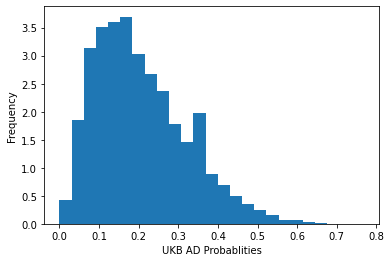

In [119]:
plt.hist(ukb_probablities, density=True, bins=25)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('UKB AD Probablities');

## Matrix Completion Time

In [120]:
relevant_cols=["eid","20023-0.0"]
meta_data_df = pd.read_csv("/ocean/projects/asc170022p/shared/Data/ukBiobank/meta_data_files/ukb49570.csv", usecols = relevant_cols)

In [121]:
ukb_subjects = list(ukb_df['data_combat.Subject_ID'].unique())

In [122]:
meta_data_df["eid"].nunique()

502417

In [123]:
meta_data_df = meta_data_df[meta_data_df['eid'].isin(ukb_subjects)]
meta_data_df=meta_data_df.dropna()

In [124]:
meta_data_df.count()

eid          30666
20023-0.0    30666
dtype: int64

In [125]:
meta_data_df['20023-0.0'].describe()

count    30666.000000
mean       537.835486
std         99.775798
min        297.000000
25%        469.000000
50%        520.000000
75%        586.000000
max       1726.000000
Name: 20023-0.0, dtype: float64

In [126]:
ukb_df=pd.merge(ukb_df,meta_data_df,left_on=['data_combat.Subject_ID'], right_on = ['eid'], how='left')


In [127]:
ukb_df.head(5)

,data_combat.Subject_ID,data_combat.Date_of_Brain_Scan,data_combat.Scanner_Proxy,data_combat.lh_bankssts_thickness.combat,data_combat.lh_caudalanteriorcingulate_thickness.combat,data_combat.lh_caudalmiddlefrontal_thickness.combat,data_combat.lh_cuneus_thickness.combat,data_combat.lh_entorhinal_thickness.combat,data_combat.lh_fusiform_thickness.combat,data_combat.lh_inferiorparietal_thickness.combat,...,data_combat.SupraTentorialVolNotVent.combat,data_combat.SupraTentorialVolNotVentVox.combat,data_combat.MaskVol.combat,data_combat.BrainSegVol.to.eTIV.combat,data_combat.MaskVol.to.eTIV.combat,data_combat.EstimatedTotalIntraCranialVol.combat,AD_Probablity,Predicted_Group,eid,20023-0.0
0,1000295,2017-10-27,Newcastle,2.296284,1.178939,2.276881,2.015306,3.044882,2.892787,2.501170,...,1.363809e+06,1.358895e+06,1.963492e+06,0.967215,1.195924,1.546517e+06,0.486,AD,1000295.0,457.0
1,1000397,2018-03-07,Newcastle,2.500101,2.969933,2.990356,1.886608,3.656489,2.944818,2.794912,...,9.951820e+05,9.904603e+05,1.562235e+06,0.774657,1.028857,1.517763e+06,0.128,Not AD,1000397.0,613.0
2,1000432,2018-07-14,Cheadle,2.734754,3.305112,2.774210,1.966005,3.201053,2.943196,2.642145,...,1.059081e+06,1.054203e+06,1.609321e+06,0.831234,1.079333,1.498252e+06,0.114,Not AD,1000432.0,429.0
3,1000591,2019-07-09,Reading,2.779423,2.344385,3.093786,2.079017,3.275997,3.038995,2.591875,...,1.179758e+06,1.177390e+06,1.834101e+06,0.806057,1.083917,1.700009e+06,0.058,Not AD,1000591.0,617.0
4,1000882,2017-11-16,Cheadle,2.448656,2.768825,2.991334,1.804743,3.340516,2.790543,2.651284,...,1.269282e+06,1.264942e+06,1.865044e+06,0.789774,1.006210,1.843770e+06,0.264,Not AD,1000882.0,386.0


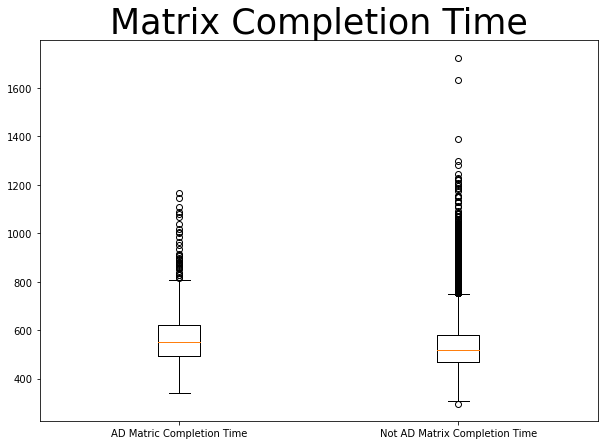

In [128]:
fig = plt.figure(figsize =(10, 7))
data=[ukb_df[ukb_df["Predicted_Group"]=="AD"]["20023-0.0"].dropna(),ukb_df[ukb_df["Predicted_Group"]=="Not AD"]["20023-0.0"].dropna()]
labels =["AD Matric Completion Time","Not AD Matrix Completion Time"]
plt.boxplot(data,labels=labels)
plt.title("Matrix Completion Time",fontsize=35)
plt.show()

In [129]:
# fig = plt.figure(figsize =(10, 7))
# plt.boxplot(meta_data_df['20023-0.0'])
# #plt.ylabel("Matrix Completion Time", fontsize=25)
# plt.title("Matrix Completion Time",fontsize=35)
# plt.show()

In [130]:
meta_data_df.head(5)

,eid,20023-0.0
28,1000295,457.0
38,1000397,613.0
42,1000432,429.0
58,1000591,617.0
87,1000882,386.0


(array([2.2817e+04, 7.5410e+03, 2.9100e+02, 1.5000e+01, 2.0000e+00]),
 array([ 297. ,  582.8,  868.6, 1154.4, 1440.2, 1726. ]),
 <BarContainer object of 5 artists>)

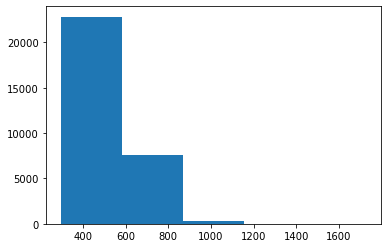

In [131]:
plt.hist(meta_data_df['20023-0.0'],bins=5)

In [1]:
import pandas as pd

In [2]:
relevant_cols=["eid","1707-0.0","1707-1.0","1707-2.0"]
meta_data_df = pd.read_csv("/ocean/projects/asc170022p/shared/Data/ukBiobank/meta_data_files/ukb49570.csv", usecols = relevant_cols)


In [3]:
brain_df=pd.read_csv("/ocean/projects/asc170022p/shared/Data/ukBiobank/meta_data_files/ukb_brain_imaging_metadata.csv")

In [7]:
ukb_brain_subjects=list(brain_df["eid"].unique())

In [8]:
meta_data_df = meta_data_df[meta_data_df['eid'].isin(ukb_brain_subjects)]

In [9]:
meta_data_df.shape

(49400, 4)

In [10]:
# 1 right handed
# 2 right handed
# can use both
meta_data_df['1707-0.0'].value_counts()

 1.0    43952
 2.0     4636
 3.0      789
-3.0        9
Name: 1707-0.0, dtype: int64

In [11]:
meta_data_df['1707-1.0'].value_counts()

1.0    7424
2.0     767
3.0     135
Name: 1707-1.0, dtype: int64

In [12]:
meta_data_df['1707-2.0'].value_counts()

 1.0    10356
 2.0     1098
 3.0      210
-3.0        3
Name: 1707-2.0, dtype: int64